# ARIMA Forecasting


Autoregressive Integrated Moving Average Model

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Any "non-seasonal" time series that contains patterns over time can be modeled with ARIMA by utilising its own lagged values and lagged forecast errors in order to forecast future values.

This is an ARIMA model implementation using purely kdb

In [1]:
\l ../tm.q
.tm.loadfile`:init.q
\l ../utils.q

## Daily Temp

### Data Preparation

The below dataset contains the mimimum daily temperatures reached in Melbourne during the period from January 1981 - December 1990.

Null values are removed from the dataset

In [2]:
show mintemp:`date`temp xcol ("PF";enlist",")0:`:../data/dailytemp.csv

// Delete any nulls from the data
mintemp:delete from mintemp where temp=0N

date                          temp
----------------------------------
1981.01.01D00:00:00.000000000 20.7
1981.01.02D00:00:00.000000000 17.9
1981.01.03D00:00:00.000000000 18.8
1981.01.04D00:00:00.000000000 14.6
1981.01.05D00:00:00.000000000 15.8
1981.01.06D00:00:00.000000000 15.8
1981.01.07D00:00:00.000000000 15.8
1981.01.08D00:00:00.000000000 17.4
1981.01.09D00:00:00.000000000 21.8
1981.01.10D00:00:00.000000000 20  
1981.01.11D00:00:00.000000000 16.2
1981.01.12D00:00:00.000000000 13.3
1981.01.13D00:00:00.000000000 16.7
1981.01.14D00:00:00.000000000 21.5
1981.01.15D00:00:00.000000000 25  
1981.01.16D00:00:00.000000000 20.7
1981.01.17D00:00:00.000000000 20.6
1981.01.18D00:00:00.000000000 24.8
1981.01.19D00:00:00.000000000 17.7
1981.01.20D00:00:00.000000000 15.5
..


The data is plotted below to portray the trends and cycles present in the dataset

/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


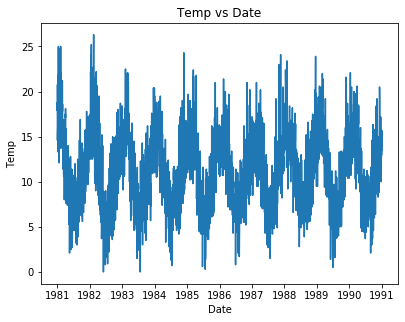

In [3]:
plttm[mintemp`date;mintemp`temp;"Temp"]

Arima does not account for missing timestamps, these values must be added and then back/forward filled in order for the model to pick up on the trends in the dataset

In [4]:
mintemp:datefill[`date;mintemp;1D]

// back and forward fill data
mintemp:.ml.filltab[mintemp;();`date;::]

dt:mintemp`date
// Timestamp component is broken into its constituent parts
mintemp:.ml.timesplit[mintemp;`date] 

-1"\nThe new timestamp columns created include:\n";
string -9#cols[mintemp]

// Back and forward fill the missing data
mintemp:.ml.dropconstant[mintemp]


The new timestamp columns created include:



"date_dow"
"date_year"
"date_mm"
"date_dd"
"date_qtr"
"date_wd"
"date_hh"
"date_uu"
"date_ss"


In [5]:
// Delete any null_ cols - too many 0 values for model to preform well
delcols:cols[mintemp] where cols[mintemp] like"*_null"

mintemp:![mintemp;();0b;delcols]

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data. The x are defined as the inputs and temperature as the target values

In [6]:
// Find the timestamp which splits the data 80/20
tts:ttstm[delete temp from mintemp;mintemp`temp;.2]

// The data is then split into the training and testing sets
xtraintmp:tts`xtrain
ytraintmp:tts`ytrain
xtesttmp:tts`xtest
ytesttmp:tts`ytest

-1!"There is ",string[count xtraintmp]," datapoints in the training set"
-1!"There is ",string[count xtesttmp]," datapoints in the testing set"

"There is 2921 datapoints in the training set"


"There is 731 datapoints in the testing set"


### Training the model

Autocorrelation indicates the relationship between a time series and its lagged values. The red dotted line indictes the 95% confidence interval. Any value above this interval is deemed to be significant

The autocorrrelation graph is used to determine what value of q to use

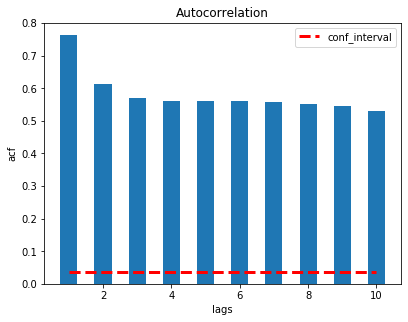

In [7]:
.tm.acfplot[ytraintmp]

Partial autocorrelation indicates the relationship between a time series and the lagged values when correlations due to shorted lagged values are removed.

The partial autocorrrelation graph is used to determine what value of p to use

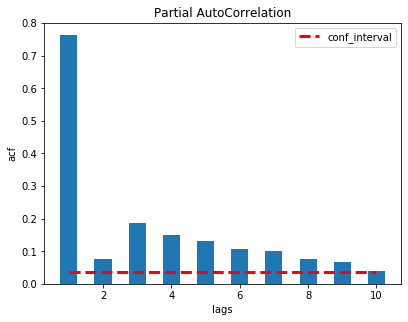

In [8]:
.tm.pacfplot[ytraintmp]

#### General Features of ACF/PACF graph


ACF      |   PACF     |  Explanation
---------|------------|---------------------
Decays to 0 | Non zero values at first p points  | AR(p) model
Non zero values at first q points  | Decays to 0 | MA(q) model 
Values remain close to 1 | Values remain close to 1 | Series is non stationary 
No correlation seen | No correlation seen  | Random time series


If a model contains both AR and MA terms, the interpretation gets trickier. In general, both will taper off to 0. There may still be spikes in the ACF and/or PACF which could lead you to try AR and MA terms of that quantity. However, it usually helps to try a few different models, and based on model diagnostics, choose which one fits best.

The inputs to the ARIMAfit:

Parameter      |  Explanation
---------------|---------------------------
endog          | The endogenous variable (predicted y value) (list)
exog          | Exogenous variables (table)
p            | Number of lag observations in the model (int)
d            | Number of times that the observations are differenced (int)
q          | Size of moving average window (int)
tr        | Add trend value (boolean)

The Hannan-Rissanen algorithm will be used to estimate the residual errors. This method includes:

        - Using a high order AutoRegressive (AR) model (using least square methods) in order make estimates and 
        calculate the residual errors. 
        
        - Ordinary least squares (OLS) is then used to estimate the lag (p) and residual error (q) coefficients
        along with any trend present or exogenous column

From the `ACF` plot, it is evident that the data is not stationary, therefor a `d` value of 1 will be passed to the model

In [9]:
\t show mdl:.tm.ARIMAfit[ytraintmp;xtraintmp;3;1;2;1b]

params    | -0.6475186 -0.08209288 0.0002328243 0.005087683 0.002651215 0.022..
tr_param  | -0.6475186
exog_param| -0.08209288 0.0002328243 0.005087683 0.002651215 0.02227677 0.420..
p_param   | -0.1048015 0.291469 -0.3678262
q_param   | -0.7183123 0.005101674
lags      | 3.4 0 1.9 -0.7
resid     | 0.6904736 -0.4691562
estresid  | -0.04788988 -0.0001910572 0.01755428 0.006241851 0.02088836 0.357..
pred_dict | `p`q`tr!(3;2;1b)
origd     | ,14.1


152


The keys of the returned dictionary to be used for forcasting

key      |  Explanation
---------------|---------------------------
params      | Model paramaters for future predictions
tr_param    | trend paramaters
exog_param | exog paramaters
p_param    | lag value paramaters
q_param     | error paramaters
lags        | lagged values from the training set
resid       | q residual errors calculated from training set using the params
estresid     | Coefficients used to estimate resid errors
origd        | Original values of input values before being differenciated

### Model Forecasting

The inputs to `.tm.ARIMApred` are 

The inputs to the ARIMAfit:

Parameter      |  Explanation
---------------|---------------------------
mdl          | Model generated by .tm.ARIMAfit
exog          | Exogenous variables (table)
steps          | How many steps in the future to forecast

and returns the predicted values

In [10]:
\t predstmp:.tm.ARIMApred[mdl;xtesttmp;count ytesttmp]

// Calculate the error
-1!"The Root mean squared log error is ",string .ml.rmsle[predstmp;ytesttmp]

11


"The Root mean squared log error is 0.3283829"


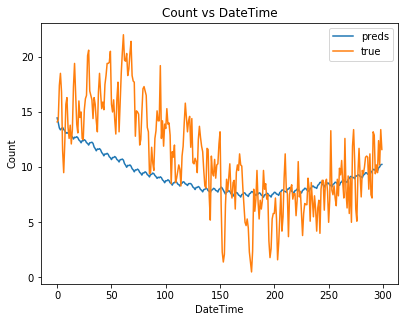

In [11]:
pltresult[300#predstmp;300#ytesttmp;"Count"]

## Bike Rental

**In this section a more complex model is used with exogenous variables included in the training of the models**

### Data Preparation

Load in the data

The dataset is a provided by TFL to predict future bike sales per hour. Additional data is also given in the form of seasonality and climate information such as season, indication of whether it is a holiday, temperature, wind_speed, current weather etc .

For the purpose of these notebook, when predictions are being made, it is assumed that these climate information will be available based off future weather predictions. 

In [12]:
show bikes:("PFFFFFFBFF";enlist ",")0:`:../data/london_merged.csv

timestamp                     cnt  t1  t2   hum  wind_speed weather_code is_h..
-----------------------------------------------------------------------------..
2015.01.04D00:00:00.000000000 182  3   2    93   6          3            0   ..
2015.01.04D01:00:00.000000000 138  3   2.5  93   5          1            0   ..
2015.01.04D02:00:00.000000000 134  2.5 2.5  96.5 0          1            0   ..
2015.01.04D03:00:00.000000000 72   2   2    100  0          1            0   ..
2015.01.04D04:00:00.000000000 47   2   0    93   6.5        1            0   ..
2015.01.04D05:00:00.000000000 46   2   2    93   4          1            0   ..
2015.01.04D06:00:00.000000000 51   1   -1   100  7          4            0   ..
2015.01.04D07:00:00.000000000 75   1   -1   100  7          4            0   ..
2015.01.04D08:00:00.000000000 131  1.5 -1   96.5 8          4            0   ..
2015.01.04D09:00:00.000000000 301  2   -0.5 100  9          3            0   ..
2015.01.04D10:00:00.000000000 528  3   -

The trends over time for the data is plotted below which shows that cyclical patterns are present in the dataset



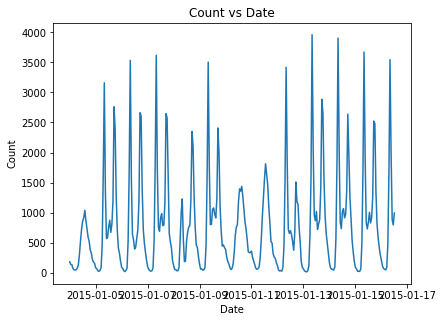

In [13]:
plttm[300#bikes`timestamp;300#bikes`cnt;"Count"]


Arima does not account for missing timestamps, these values must be added and then back/forward filled in order for the model to pick up on the trends in the dataset

In [14]:
// Include any missing datetimes
bikes:datefill[`timestamp;bikes;01:00:00.000]

// Timestamp component is broken into its constituent parts
bikes:.ml.timesplit[bikes;`timestamp] 

-1"\nThe new timestamp columns created include:\n";
string -9#cols[bikes]

// Back and forward fill the missing data
bikes:.ml.dropconstant[.ml.filltab[bikes;();`timestamp;::]]


The new timestamp columns created include:



"timestamp_dow"
"timestamp_year"
"timestamp_mm"
"timestamp_dd"
"timestamp_qtr"
"timestamp_wd"
"timestamp_hh"
"timestamp_uu"
"timestamp_ss"


In [15]:
// Delete any null_ cols - too many 0 values for model to preform well
delcols:cols[bikes] where cols[bikes] like"*_null"

bikes:![bikes;();0b;delcols]

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data.

In this scenario, the exogeneous columns are used as the input data, and bike count as the target data



In [16]:
// Find the timestamp which splits the data 80/20
tts:ttstm[delete cnt from bikes;bikes`cnt;0.2]

// The data is then split into the training and testing sets
xtrainbk:tts`xtrain
ytrainbk:tts`ytrain
xtestbk:tts`xtest
ytestbk:tts`ytest


-1!"There is ",string[count xtrainbk]," datapoints in the training set"
-1!"There is ",string[count xtestbk]," datapoints in the testing set"

"There is 14035 datapoints in the training set"


"There is 3509 datapoints in the testing set"


### Training the model


#### Choosing the right model and parameters to use

Autocorrelation indicates the relationship between a time series and its lagged values.The red dotted line indictes the 95% confidence interval. Any value above this interval is deemed to be significant

The autocorrrelation graph is used to determine what value of q to use

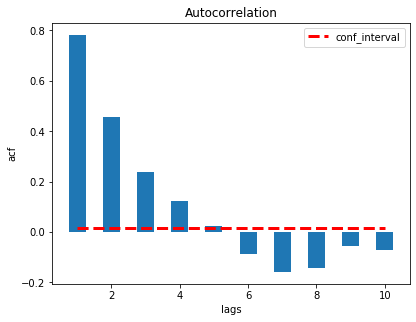

In [17]:
.tm.acfplot[ytrainbk]

Partial autocorrelation indicates the relationship between a time series and the lagged values when correlations due to shorted lagged values are removed.

The partial autocorrrelation graph is used to determine what value of p to use

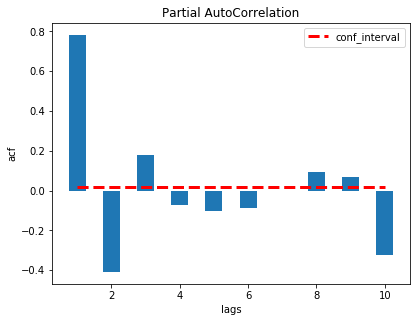

In [18]:
.tm.pacfplot[ytrainbk]

#### General Features of ACF/PACF graph


ACF      |   PACF     |  Explanation
---------|------------|---------------------
Decays to 0 | Non zero values at first p points  | AR(p) model
Non zero values at first q points  | Decays to 0 | MA(q) model 
Values remain close to 1 | Values remain close to 1 | Series is non stationary 
No correlation seen | No correlation seen  | Random time series


If a model contains both AR and MA terms, the interpretation gets trickier. In general, both will taper off to 0. There may still be spikes in the ACF and/or PACF which could lead you to try AR and MA terms of that quantity. However, it usually helps to try a few different models, and based on model diagnostics, choose which one fits best. 

#### Building the model

The inputs to the ARIMAfit:

Parameter      |  Explanation
---------------|---------------------------
endog          | The endogenous variable (predicted y value) (list)
exog          | Exogenous variables (table)
p            | Number of lag observations in the model (int)
d            | Number of times that the observations are differenced (int)
q          | Size of moving average window (int)
tr        | Add trend value (boolean)

The Hannan-Rissanen algorithm will be used to estimate the residual errors. This method includes:

        - Using a high order AutoRegressive (AR) model (using least square methods) in order make estimates and 
        calculate the residual errors. 
        
        - Ordinary least squares (OLS) is then used to estimate the lag (p) and residual error (q) coefficients
        along with any trend present or exogenous columns

In [19]:
\t show mdl:.tm.ARIMAfit[ytrainbk;xtrainbk;4;0;3;1b]

params    | -39334.99 19.21106 -5.789643 -5.091633 -2.341473 -5.255746 -25.23..
tr_param  | -39334.99
exog_param| 19.21106 -5.789643 -5.091633 -2.341473 -5.255746 -25.23679 3.4462..
p_param   | -0.3104023 0.7861802 -1.526247 1.772686
q_param   | -0.03272211 0.1271024 -0.7542801
lags      | 1602 1763 2492 4505 4379f
resid     | 234.0836 1632.401 -88.0765
estresid  | 45.60899 -13.73566 -11.75055 -5.064118 -7.323791 -75.01857 5.7983..
pred_dict | `p`q`tr!(4;3;1b)
origd     | `float$()


1453


The keys of the returned dictionary to be used for forcasting

key      |  Explanation
---------------|---------------------------
params      | Model paramaters for future predictions
tr_param    | trend paramaters
exog_param | exog paramaters
p_param    | lag value paramaters
q_param     | error paramaters
lags        | lagged values from the training set
resid       | q residual errors calculated from training set using the params
estresid     | Coefficients used to estimate resid errors
origd        | Original values of input values before being differenciated

### Model Forecasting

The future values are forecasted using the `forecast` feature of the fitted model. The additional columns are also included in the forecast to aid with predictions. 

The forecasted values are used to calculated the associated error


The inputs to `.tm.ARIMApred` are 

The inputs to the ARIMAfit:

Parameter      |  Explanation
---------------|---------------------------
mdl          | Model generated by .tm.ARIMAfit (dictionary)
exog          | Exogenous variables (table)
steps          | How many steps in the future to forecast (int)

and returns the predicted values

In [20]:
\t predsbk:.tm.ARIMApred[mdl;xtestbk;1000]

// Calculate the error
-1!"The Root mean squared log error is ",string .ml.rmsle[predsbk;1000#ytestbk]

12


"The Root mean squared log error is 0.9054304"


The predicted and real values are also plotted to show how the models forecasted values varied from the true values



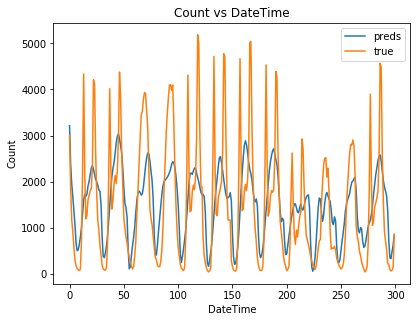

In [21]:
pltresult[300#predsbk;300#ytestbk;"Count"]

Similar to the methods illustrated above, a pure AR(p)/MA(q) model along with a ARMA(p,q) model can be implemented using the following functions

Fitting the model:

mdlnm          |  params
---------------|-------------------
ARfit          | (endog;exog;p;tr)
MAfit          | (endog;exog;q;tr)
ARMAfit        | (endog;exog;p;q;tr)

Forecasting future values

mdlnm          |  params
---------------|-------------------
ARpred          | (mdl;exog;len)
MApred          | (mdl;exog;len)
ARMApred        | (mdl;exog;len)

### Comparing Different input values using AIC

The Akaike Information Critera (AIC) is a used to measure a statistical model by taking into account the goodness of fit and the simplicity of the model. The lower the score signifies the better the model. 

The formula is:

`AIC = -2log(L) + 2(p+q+k+1)`

Where 

`L` is the liklihood of the data (How well it preforms)

`q` `p` `k` are the parameters

The inputs to the function are 

`traindict` - A dictionary of training endogenous and exogenous values

`testdict` - A dictionary of testing endogenous and exogenous values

`param` - A dictionary of the parameters `p, d, q, tr`

In [22]:
traindict:`endog`exog!(ytraintmp;xtraintmp)
testdict:`endog`exog!(ytesttmp;xtesttmp)
show param:`p`d`q`tr!(5 2 3 4;1 0 1 0;0 1 2 1;1011b)

p | 5 2 3 4
d | 1 0 1 0
q | 0 1 2 1
tr| 1 0 1 1


In [23]:
show aic:.tm.aicparam[traindict;testdict;100;param]

p    | 2
d    | 0
q    | 1
tr   | 0b
score| 304.0405
